## Data collection

In [ ]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir extracted
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data
!pip install path

Preview how the dataset is organized. Lines prepended by "#" are just metadata information.

In [ ]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


## Imports

In [ ]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

## Dataset splitting

In [ ]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

We will split the dataset into three subsets with a 90:5:5 ratio (train:validation:test).

In [ ]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


## Data input pipeline

We start building our data input pipeline by first preparing the image paths.

In [ ]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

Then we prepare the ground-truth labels.

In [ ]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))
print("All detected characters: ",characters)

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78
All detected characters:  ['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

Now we clean the validation and the test labels as well.

In [ ]:

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

### Building the character vocabulary

Keras provides different preprocessing layers to deal with different modalities of data.
[This guide](https://keras.io/guides/preprocessing_layers/) provides a comprehensive introduction.
Our example involves preprocessing labels at the character
level. This means that if there are two labels, e.g. "cat" and "dog", then our character
vocabulary should be {a, c, d, g, o, t} (without any special tokens). We use the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/)
layer for this purpose.

In [ ]:

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

print(char_to_num(['m','e','!','t']))

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

print(num_to_char([1,0,4,2]))

tf.Tensor([65 57  1 72], shape=(4,), dtype=int64)
tf.Tensor([b'!' b'[UNK]' b'&' b'"'], shape=(4,), dtype=string)


### Resizing images without distortion

Instead of square images, many OCR models work with rectangular images. This will become
clearer in a moment when we will visualize a few samples from the dataset. While
aspect-unaware resizing square images does not introduce a significant amount of
distortion this is not the case for rectangular images. But resizing images to a uniform
size is a requirement for mini-batching. So we need to perform our resizing such that
the following criteria are met:

* Aspect ratio is preserved.
* Content of the images is not affected.

In [ ]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


If we just go with the plain resizing then the images would look like so:

![](https://i.imgur.com/eqq3s4N.png)

Notice how this resizing would have introduced unnecessary stretching.

### Putting the utilities together

In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

## Visualize a few samples

tf.Tensor(
[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.      

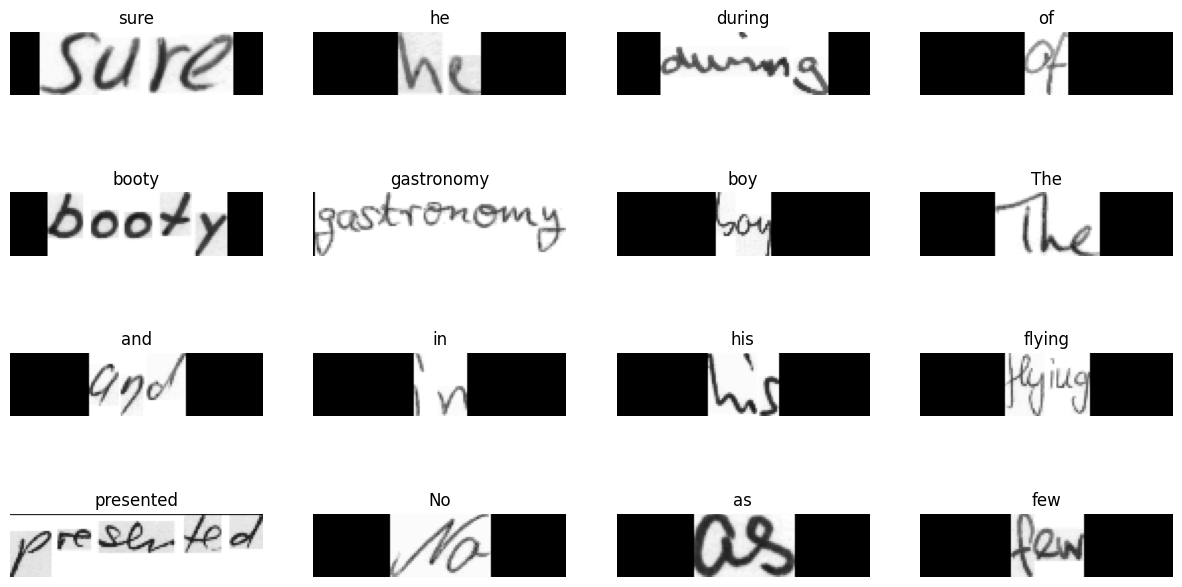

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    print(images)
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        # print(img)
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        # print(label,indices)
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

the content of original image is kept as faithful as possible and has
been padded accordingly.

## Model

Our model will use the CTC loss as an endpoint layer. ref.: [this post](https://distill.pub/2017/ctc/).

In [ ]:

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64.
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

## Evaluation metric


We first segregate the validation images and their labels for convenience.

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

Now, we create a callback to monitor the edit distances.

In [ ]:

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


## Training

Now we are ready to kick off model training.

In [ ]:
epochs = 60  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


Epoch 1/60
 117/1357 [=>............................] - ETA: 1:58 - loss: 19.8388

KeyboardInterrupt: 

## Inference

2/2 [==============================] - 3s 17ms/step


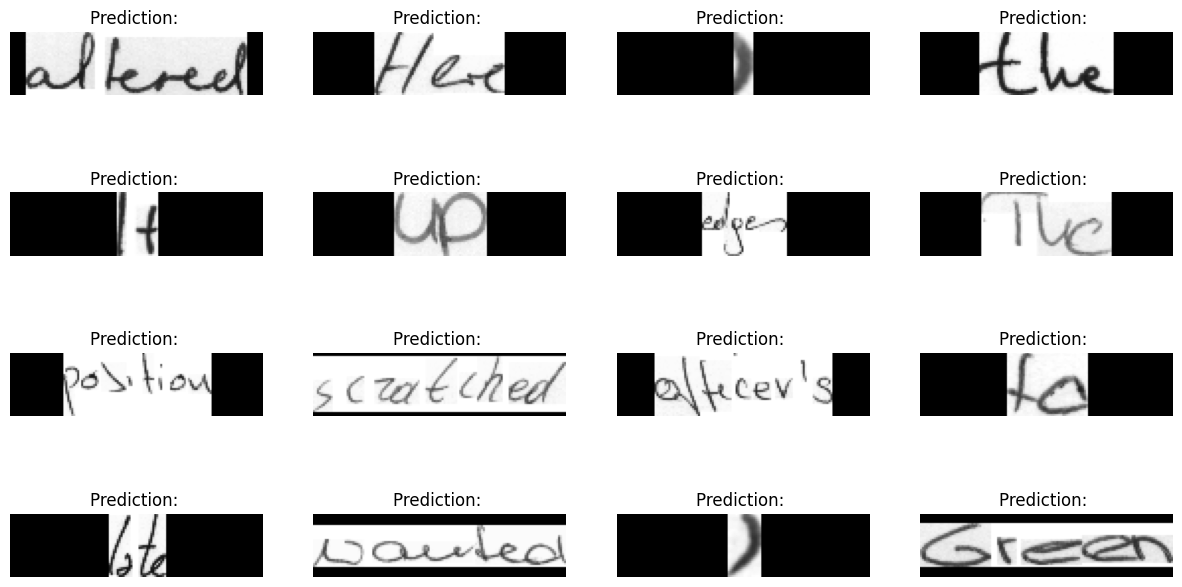

In [ ]:

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    # print(batch_images)
    _, ax = plt.subplots(4, 4, figsize=(15, 8))
    preds = prediction_model.predict(batch_images)
    # print(preds)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Calculate the accuracy of the model.
accuracy = classification_report(test_labels_cleaned[:64], pred_texts, output_dict=True)['accuracy']

# Print the accuracy of the model.
print('Accuracy:', accuracy*100)


To get better results the model should be trained for at least 50 epochs.

In [ ]:
from collections import defaultdict
from dataclasses import dataclass
from typing import List

import math

import cv2
import numpy as np
from sklearn.cluster import DBSCAN


@dataclass
class BBox:
    x: int
    y: int
    w: int
    h: int


@dataclass
class DetectorRes:
    img: np.ndarray
    bbox: BBox


def detect(img: np.ndarray,
           kernel_size: int,
           sigma: float,
           theta: float,
           min_area: int) -> List[DetectorRes]:
    """Scale space technique for word segmentation proposed by R. Manmatha.

    For details see paper http://ciir.cs.umass.edu/pubfiles/mm-27.pdf.

    Args:
        img: A grayscale uint8 image.
        kernel_size: The size of the filter kernel, must be an odd integer.
        sigma: Standard deviation of Gaussian function used for filter kernel.
        theta: Approximated width/height ratio of words, filter function is distorted by this factor.
        min_area: Ignore word candidates smaller than specified area.

    Returns:
        List of DetectorRes instances, each containing the bounding box and the word image.
    """
    assert img.ndim == 2
    assert img.dtype == np.uint8

    # apply filter kernel
    kernel = _compute_kernel(kernel_size, sigma, theta)
    img_filtered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    img_thres = 255 - cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    cv2.imwrite("kernel.jpg", kernel)
    cv2.imwrite("filter_img.jpg", img_filtered)
    cv2.imwrite("thres.jpg", img_thres)

    # append components to result
    res = []
    components = cv2.findContours(img_thres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]

    for c in components:
        # skip small word candidates
        if cv2.contourArea(c) < min_area:
            continue
        # append bounding box and image of word to result list
        x, y, w, h = cv2.boundingRect(c)  # bounding box as tuple (x, y, w, h)
        crop = img[y:y + h, x:x + w]
        res.append(DetectorRes(crop, BBox(x, y, w, h)))

    return res


def _compute_kernel(kernel_size: int,
                    sigma: float,
                    theta: float) -> np.ndarray:
    """Compute anisotropic filter kernel."""

    assert kernel_size % 2  # must be odd size

    # create coordinate grid
    half_size = kernel_size // 2
    xs = ys = np.linspace(-half_size, half_size, kernel_size)
    x, y = np.meshgrid(xs, ys)

    # compute sigma values in x and y direction, where theta is roughly the average x/y ratio of words
    sigma_y = sigma
    sigma_x = sigma_y * theta

    # compute terms and combine them
    exp_term = np.exp(-x ** 2 / (2 * sigma_x) - y ** 2 / (2 * sigma_y))
    x_term = (x ** 2 - sigma_x ** 2) / (2 * math.pi * sigma_x ** 5 * sigma_y)
    y_term = (y ** 2 - sigma_y ** 2) / (2 * math.pi * sigma_y ** 5 * sigma_x)
    kernel = (x_term + y_term) * exp_term

    # normalize and return kernel
    kernel = kernel / np.sum(kernel)
    return kernel


def prepare_img(img: np.ndarray,
                height: int) -> np.ndarray:
    """Convert image to grayscale image (if needed) and resize to given height."""
    assert img.ndim in (2, 3)
    assert height > 0
    assert img.dtype == np.uint8
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h = img.shape[0]
    factor = height / h
    return cv2.resize(img, dsize=None, fx=factor, fy=factor)


def _cluster_lines(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    # compute matrix containing Jaccard distances (which is a proper metric)
    num_bboxes = len(detections)
    dist_mat = np.ones((num_bboxes, num_bboxes))
    for i in range(num_bboxes):
        for j in range(i, num_bboxes):
            a = detections[i].bbox
            b = detections[j].bbox
            if a.y > b.y + b.h or b.y > a.y + a.h:
                continue
            intersection = min(a.y + a.h, b.y + b.h) - max(a.y, b.y)
            union = a.h + b.h - intersection
            iou = np.clip(intersection / union if union > 0 else 0, 0, 1)
            dist_mat[i, j] = dist_mat[j, i] = 1 - iou  # Jaccard distance is defined as 1-iou

    dbscan = DBSCAN(eps=max_dist, min_samples=min_words_per_line, metric='precomputed').fit(dist_mat)

    clustered = defaultdict(list)
    for i, cluster_id in enumerate(dbscan.labels_):
        if cluster_id == -1:
            continue
        clustered[cluster_id].append(detections[i])

    res = sorted(clustered.values(), key=lambda line: [det.bbox.y + det.bbox.h / 2 for det in line])
    return res


def sort_multiline(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    """Cluster detections into lines, then sort the lines according to x-coordinates of word centers.

    Args:
        detections: List of detections.
        max_dist: Maximum Jaccard distance (0..1) between two y-projected words to be considered as neighbors.
        min_words_per_line: If a line contains less words than specified, it is ignored.

    Returns:
        List of lines, each line itself a list of detections.
    """
    lines = _cluster_lines(detections, max_dist, min_words_per_line)
    res = []
    for line in lines:
        res += sort_line(line)
    return res


def sort_line(detections: List[DetectorRes]) -> List[List[DetectorRes]]:
    """Sort the list of detections according to x-coordinates of word centers."""
    return [sorted(detections, key=lambda det: det.bbox.x + det.bbox.w / 2)]


Processing file ./page/r06-137.png


<ipython-input-20-85a964e909e3>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('rainbow', num_colors)


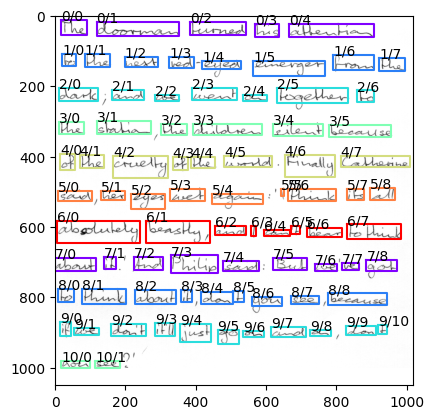

In [ ]:
import argparse
from typing import List

import cv2
import matplotlib.pyplot as plt
from path import Path


line_wise_img = []
pred_img_paths = []


def get_img_files(data_dir: Path) -> List[Path]:
    """Return all image files contained in a folder."""
    res = []
    for ext in ['*.png', '*.jpg', '*.bmp']:
        res += Path(data_dir).files(ext)
    return res


def main():
    parsed = {
        "data": Path('./page'),
        "kernel_size":25,
        "sigma": 11,
        "theta": 5,
        "min_area": 100,
        "img_height": 1000
    }


    for fn_img in get_img_files(parsed["data"]):
        print(f'Processing file {fn_img}')

        # load image and process it
        img = prepare_img(cv2.imread(fn_img), parsed["img_height"])
        detections = detect(img,
                            kernel_size=parsed["kernel_size"],
                            sigma=parsed["sigma"],
                            theta=parsed["theta"],
                            min_area=parsed["min_area"])


        # sort detections: cluster into lines, then sort each line
        lines = sort_multiline(detections)

        # plot results
        plt.imshow(img, cmap='gray')
        num_colors = 7
        colors = plt.cm.get_cmap('rainbow', num_colors)
        for line_idx, line in enumerate(lines):
            img_paths = []
            for word_idx, det in enumerate(line):
                xs = [det.bbox.x, det.bbox.x, det.bbox.x +
                      det.bbox.w, det.bbox.x + det.bbox.w, det.bbox.x]
                ys = [det.bbox.y, det.bbox.y + det.bbox.h,
                      det.bbox.y + det.bbox.h, det.bbox.y, det.bbox.y]
                plt.plot(xs, ys, c=colors(line_idx % num_colors))
                plt.text(det.bbox.x, det.bbox.y, f'{line_idx}/{word_idx}')
                crop_img = img[det.bbox.y:det.bbox.y +
                               det.bbox.h, det.bbox.x:det.bbox.x+det.bbox.w]
                cv2.imwrite("extracted/line"+str(line_idx)+"word" +
                            str(word_idx)+".jpg", crop_img)
                img_paths.append("extracted/line"+str(line_idx)+"word" +
                            str(word_idx)+".jpg");
                pred_img_paths.append("extracted/line"+str(line_idx)+"word" +
                            str(word_idx)+".jpg");

            line_wise_img.append(img_paths)

        plt.show()


main()

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def prepare_dataset(pred_img_paths):
    dataset = tf.data.Dataset.from_tensor_slices((pred_img_paths)).map(
        preprocess_image, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(len(pred_img_paths)).cache().prefetch(AUTOTUNE)


ds = prepare_dataset(pred_img_paths)

for bt_img in ds.take(1):
    # print(bt_img)
    preds = prediction_model.predict(bt_img)
    pred_texts = decode_batch_predictions(preds)
    # for i in range(len(bt_img)):
    #   img = bt_img[i]
    #   img = tf.image.flip_left_right(img)
    #   img = tf.transpose(img, perm=[1, 0, 2])
    #   img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    #   img = img[:, :, 0]
    #   print(pred_texts[i])
      # cv2_imshow(img)

prev = 0
j = 0
for i in range(len(pred_texts)):
    if(i-prev == len(line_wise_img[j])):
      j += 1
      prev = i
      print()
    print(pred_texts[i],end=" ")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save('/content/drive/My Drive/my_model.h5')

drive.flush_and_unmount()


KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!cp "/content/drive/My Drive/Colab Notebooks/my_model.h5" "/content/"

drive.flush_and_unmount()


Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope


def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text



class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred



# Register the custom layer when loading the model
with CustomObjectScope({'CTCLayer': CTCLayer}):
    model = tf.keras.models.load_model('my_model.h5')
    pm = keras.models.Model(
          model.get_layer(name="image").input, model.get_layer(name="dense2").output
    )
    def prepare_dataset(pred_img_paths):
      dataset = tf.data.Dataset.from_tensor_slices((pred_img_paths)).map(
          preprocess_image, num_parallel_calls=AUTOTUNE
      )
      return dataset.batch(len(pred_img_paths)).cache().prefetch(AUTOTUNE)


    ds = prepare_dataset(pred_img_paths)

    for bt_img in ds.take(1):
        # print(bt_img)
        preds = pm.predict(bt_img)
        pred_texts = decode_batch_predictions(preds)
        # for i in range(len(bt_img)):
        #   img = bt_img[i]
        #   img = tf.image.flip_left_right(img)
        #   img = tf.transpose(img, perm=[1, 0, 2])
        #   img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        #   img = img[:, :, 0]
        #   print(pred_texts[i])
          # cv2_imshow(img)

    prev = 0
    j = 0
    for i in range(len(pred_texts)):
        if(i-prev == len(line_wise_img[j])):
          j += 1
          prev = i
          print()
        print(pred_texts[i],end=" ")

3/3 [==============================] - 2s 85ms/step
The doorman turned his attention 
to the next red ened emerger from the 
dark and we went on tosether to 
the station the children silent because 
of the cruetty of the world finally Catherine 
sad her eyes wet agan , think its all 
abodutely beasthgy and I can 't bear tothink 
about it And Philis said But we we aot 
to think about it dow It yon see because 
if we don't itll just go on and on don It 
non see 